Here I'll go over the process of loading the DICOM images in python with pydicom and doing some light processing tasks on them

Initial Loading
---------------

In [1]:
%pylab --no-import-all
%matplotlib inline
import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage

images_path = '../input/sample_images/'

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_3d_data(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    return np.stack([s.pixel_array for s in slices])

the get_3d_data function above reads all the files, orders the slices, and returns all the data as a 3D numpy array. With that we can visualize slices in any planes on the data, or pass it directly as 3D data to a CNN

In [3]:
patients = os.listdir(images_path)
patients.sort()

sample_image = get_3d_data(images_path + patients[0])
sample_image.shape

(134, 512, 512)

In [4]:
#the images have the unavailable pixel set to -2000, changing them to 0 makes the picture clearer
sample_image[sample_image == -2000] = 0

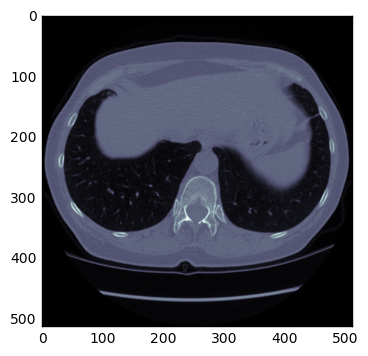

In [5]:
#same plane as the original data, cut at the Z axis
pylab.imshow(sample_image[100], cmap=pylab.cm.bone)
pylab.show()

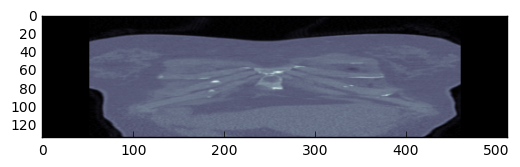

In [6]:
#cut at the Y axis
pylab.imshow(sample_image[:, 100, :], cmap=pylab.cm.bone)
pylab.show()

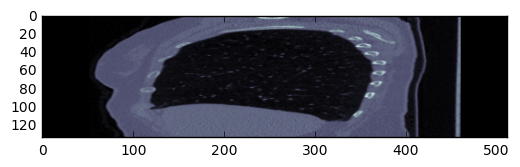

In [7]:
#cut at the X axis
pylab.imshow(sample_image[:, :, 100], cmap=pylab.cm.bone)
pylab.show()

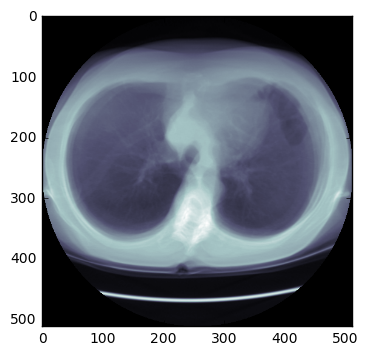

In [8]:
#can also do some operations on the images directly, mostly useful for exploration
pylab.imshow(np.average(sample_image, 0), cmap=pylab.cm.bone)
pylab.show()

Processing the Images
---------------------

It's often a good idea to pre-process the images before doing anything with them. In this case, it makes sense to normalize the images either by slice or as the 3D whole.

In [9]:
#remaping the image to 1 standard deviation of the average and clipping it to 0-1
img_std = np.std(sample_image)
img_avg = np.average(sample_image)
std_image = np.clip((sample_image - img_avg + img_std) / (img_std * 2), 0, 1)

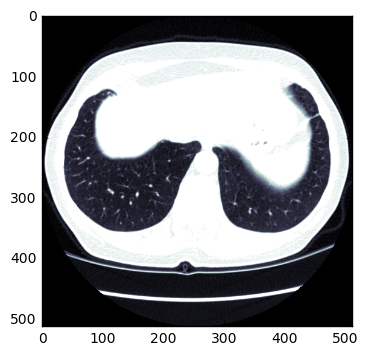

In [10]:
#same cut as before, a bit easier to spot the features
pylab.imshow(std_image[100], cmap=pylab.cm.bone)
pylab.show()

Silly CNN example
-----------------

I'll show a quick example on how to process all the sample images and use them directly to train a CNN.

I initially tried to just shove the 3D images on my GPU, but it didn't have enough RAM to handle the massive images, so I had to downsample them. Oddly enough, it still somewhat works.

In [11]:
# load training labels
labels_csv = pd.read_csv(images_path + '../stage1_labels.csv', index_col='id')

# Remove the (single) unlabbeled patient from our list
patients = labels_csv.ix[patients].dropna().index

# And finally get the training labels
train_labels = labels_csv.ix[patients].cancer.astype(np.float16).as_matrix()
train_labels = train_labels.reshape([len(train_labels), 1])

In [12]:
# Loads, resizes and processes the image
def process_image(path):
    img = get_3d_data(path)
    img[img == -2000] = 0
    img = scipy.ndimage.zoom(img.astype(np.float), 0.25)
    img_std = np.std(img)
    img_avg = np.average(img)
    return np.clip((img - img_avg + img_std) / (img_std * 2), 0, 1).astype(np.float16)

In [13]:
train_features = np.zeros([len(patients), 1, 128, 128, 128], np.float16)
for i in range(len(patients)):
    f = process_image(images_path + patients[i])
    f = np.concatenate([f, np.zeros([128 - f.shape[0], 128, 128], np.float16)]) # Pads the image
    f = f.reshape([1, 128, 128, 128]) # add an extra dimension for the color channel
    train_features[i] = f
train_features.shape

/opt/conda/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


(19, 1, 128, 128, 128)

In [14]:
# This is a 5 minute CNN model roughly based on VGG, don't try to find any deep insights here, it's mostly random
import keras

nn = keras.models.Sequential([
        keras.layers.convolutional.Convolution3D(32, 3, 3, 3, border_mode='same', activation='relu', input_shape=train_features.shape[1:], dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(32, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(64, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(64, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(128, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.MaxPooling3D((2, 2, 2), (2, 2, 2), dim_ordering='th'),
        keras.layers.convolutional.Convolution3D(256, 3, 3, 3, border_mode='same', activation='relu', dim_ordering='th'),
        keras.layers.convolutional.AveragePooling3D((4, 4, 4), dim_ordering='th'),
        keras.layers.core.Flatten(),
        keras.layers.core.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.core.Dense(1, activation='sigmoid')
    ])
nn.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Using TensorFlow backend.


In [15]:
# Finally train the CNN
# nn.fit(train_features, train_labels, batch_size=1, validation_split=0.1, nb_epoch=1)

Not running the nn.fit here, the kernel worker doesn't seems to have a GPU, or there's some trick to getting Keras to use it. Here's my local output:

    Train on 17 samples, validate on 2 samples
    Epoch 1/10
    17/17 [==============================] - 13s - loss: 0.6884 - acc: 0.6471 - val_loss: 0.6530 - val_acc: 1.0000
    Epoch 2/10
    17/17 [==============================] - 13s - loss: 0.6743 - acc: 0.7059 - val_loss: 0.6346 - val_acc: 1.0000
    Epoch 3/10
    17/17 [==============================] - 13s - loss: 0.6659 - acc: 0.7059 - val_loss: 0.6119 - val_acc: 1.0000
    Epoch 4/10
    17/17 [==============================] - 13s - loss: 0.6576 - acc: 0.7059 - val_loss: 0.5866 - val_acc: 1.0000
    Epoch 5/10
    17/17 [==============================] - 13s - loss: 0.6493 - acc: 0.7059 - val_loss: 0.5643 - val_acc: 1.0000
    Epoch 6/10
    17/17 [==============================] - 13s - loss: 0.6438 - acc: 0.7059 - val_loss: 0.5382 - val_acc: 1.0000
    Epoch 7/10
    17/17 [==============================] - 13s - loss: 0.6398 - acc: 0.7059 - val_loss: 0.5085 - val_acc: 1.0000
    Epoch 8/10
    17/17 [==============================] - 12s - loss: 0.6314 - acc: 0.7059 - val_loss: 0.5031 - val_acc: 1.0000
    Epoch 9/10
    17/17 [==============================] - 12s - loss: 0.6259 - acc: 0.7059 - val_loss: 0.4861 - val_acc: 1.0000
    Epoch 10/10
    17/17 [==============================] - 12s - loss: 0.6231 - acc: 0.7059 - val_loss: 0.4663 - val_acc: 1.0000

Not too surprisingly, it was fitting the network, but with such a small sample size, it's unlikely to be able to produce anything else than an overfitted random number. It's unlikely this simplistic architecture will do anything with the still smallish full training set, but I'll probably try it just to see what happens.

I'll probably add the final prediction and CSV generation soon too :-)